# Project title : Divorce Prediction

#### Introduction
- In today's society, marital stability is a cornerstone of family well-being, yet many marriages face challenges that can lead to divorce. 
- Understanding the factors that contribute to divorce can help in developing interventions to promote healthier relationships and reduce the incidence of divorce. 
- This project leverages data science techniques to predict the likelihood of divorce based on survey responses, providing valuable insights into the predictors of marital dissolution.

#### Problem Statement
- Divorce is a complex issue influenced by many factors. The challenge is to predict divorce accurately and to identify the most significant predictors.

### 1. About the dataset ###

Dataset is derived from a study focused on predicting divorce. The dataset comprises responses collected from participants, consisting of both divorced and married couples.
- Target: The last column "Class" is the status column, which indicates whether the individual is 'Married' (represented as '1') or 'Divorced'(represented as '0').
- Variables: There are 54 questions, labeled Atr1 to Atr54, corresponding to Question 1 to Question 54.

### 2. Import libraries & read the data ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import os
import time

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier

from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline

In [2]:
#!pip install kaggle

In [3]:
# Import the kaggle API library
from kaggle.api.kaggle_api_extended import KaggleApi

In [4]:
# Initialize Kaggle API
api = KaggleApi()

# Authenticate with my Kaggle credentials
api.authenticate()
# this will return error if downloaded 'kaggle.json' file (that contains API credentials) is not saved into C:\Users\YourUsername\.kaggle

In [5]:
# Download and unzip the dataset
# For the first argument (dataset_name): If the URL is https://www.kaggle.com/username/dataset-name, then the dataset_name is username/dataset-name.
dataset_path = 'rabieelkharoua/split-or-stay-divorce-predictor-dataset'
api.dataset_download_files(dataset_path, path = 'dataset', unzip=True)

# Check the downloaded file
for path, subdirs, files in os.walk('dataset'):
    path = path          # path = 'dataset\divorce'
    #subdirs = subdirs   # subdirs = []
    files = files        # files = ['divorce.csv', 'divorce.xlsx']

df_ori = pd.read_csv(f"{path}/{files[0]}", delimiter=';')

Dataset URL: https://www.kaggle.com/datasets/rabieelkharoua/split-or-stay-divorce-predictor-dataset


In [6]:
selected_col = [col for col in df_ori.columns if col != 'Class']

# Copy the DataFrame to avoid modifying the original data
df = df_ori.copy()

np.random.seed(42)

for col in selected_col:
    num_rows = int(0.4 * len(df_ori[col]))     # Calculate the number of rows to shuffle (40% of the total rows)
    random_indices = np.random.choice(df_ori.index, size=num_rows, replace=False)
    df.loc[random_indices, col] = np.random.permutation(df.loc[random_indices, col])

### 3. Explore and prepare the data ###

In [7]:
df.head()

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,...,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
0,2,4,4,1,0,0,0,0,0,2,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,3,0,0,0,4,4,4,...,3,0,3,4,4,4,4,2,4,1
2,3,2,0,2,1,2,2,1,4,0,...,3,2,3,1,4,2,2,0,2,1
3,3,2,3,2,3,0,3,3,1,2,...,2,2,4,4,4,1,2,3,1,1
4,4,3,0,1,1,1,0,2,0,0,...,2,1,2,3,2,2,0,1,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Atr1    170 non-null    int64
 1   Atr2    170 non-null    int64
 2   Atr3    170 non-null    int64
 3   Atr4    170 non-null    int64
 4   Atr5    170 non-null    int64
 5   Atr6    170 non-null    int64
 6   Atr7    170 non-null    int64
 7   Atr8    170 non-null    int64
 8   Atr9    170 non-null    int64
 9   Atr10   170 non-null    int64
 10  Atr11   170 non-null    int64
 11  Atr12   170 non-null    int64
 12  Atr13   170 non-null    int64
 13  Atr14   170 non-null    int64
 14  Atr15   170 non-null    int64
 15  Atr16   170 non-null    int64
 16  Atr17   170 non-null    int64
 17  Atr18   170 non-null    int64
 18  Atr19   170 non-null    int64
 19  Atr20   170 non-null    int64
 20  Atr21   170 non-null    int64
 21  Atr22   170 non-null    int64
 22  Atr23   170 non-null    int64
 23  Atr24   170 non

In [9]:
df.describe()

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,...,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,1.776471,1.652941,1.764706,1.482353,1.541176,0.747059,0.494118,1.452941,1.458824,1.576471,...,2.552941,2.270588,2.741176,2.382353,2.429412,2.476471,2.517647,2.241176,2.011765,0.494118
std,1.627257,1.468654,1.415444,1.504327,1.632169,0.904046,0.898698,1.546371,1.557976,1.421529,...,1.371786,1.586841,1.137348,1.511587,1.405090,1.260238,1.476537,1.505634,1.667611,0.501442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,...,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000,0.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000


In [10]:
# Count the number of outliers in each column
# Since max rating for survey questions is 4, we check if there is any column with numeric number >4

outliers_count = (df > 4).sum()
outliers_count_sorted = outliers_count.sort_values(ascending=False)

# Display the count of outliers in each column
print("Count of outliers by column, in descending order:")
print(outliers_count_sorted.head())

Count of outliers by column, in descending order:
Atr1     0
Atr42    0
Atr31    0
Atr32    0
Atr33    0
dtype: int64


- No null value observed.
- No outlier number observed.
- Hence data cleaning is not needed.

### 4. EDA ###

In [11]:
# Calculate point-biserial correlation
# Point-Biserial Correlation is a specialized form of the Pearson correlation tailored for scenarios involving a binary and a continuous variable.
# It measures the difference in means of the continuous variable between the two groups defined by the binary variable. 
# It also considers the standard deviation of the continuous variable and the proportions of the binary variable.

corr_pb = df.corrwith(df['Class'])
corr_pb = corr_pb.sort_values(ascending=False)[1:]

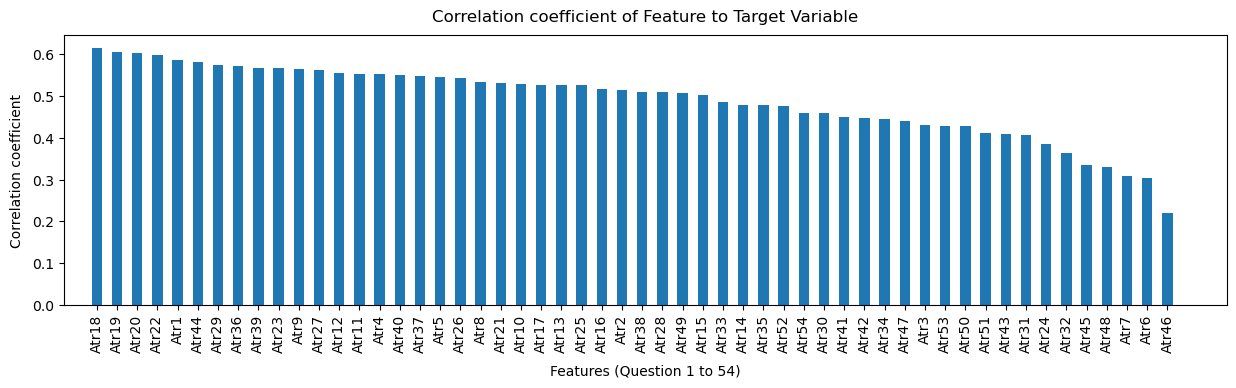

In [12]:
# Display correlation results in bar chart
num_bars = len(corr_pb)
bar_width = 1.6
bar_spacing = 1.5
bar_positions = np.arange(num_bars) * (bar_width + bar_spacing)

plt.figure(figsize=(15,3.5))
plt.bar(bar_positions, corr_pb, width=bar_width)
plt.gca().set_xlim(-5)
plt.xticks(bar_positions, corr_pb.index)
plt.xticks(rotation=90)
plt.xlabel('Features (Question 1 to 54)', labelpad=8)
plt.ylabel('Correlation coefficient', labelpad=6)
plt.title('Correlation coefficient of Feature to Target Variable', pad=10)
plt.show()

- Each feature contributes to the target variable to a certain extent, without any single feature showing notably stronger correlation compared to the others.
- We will train supervised classification models that captures contribution of these features.

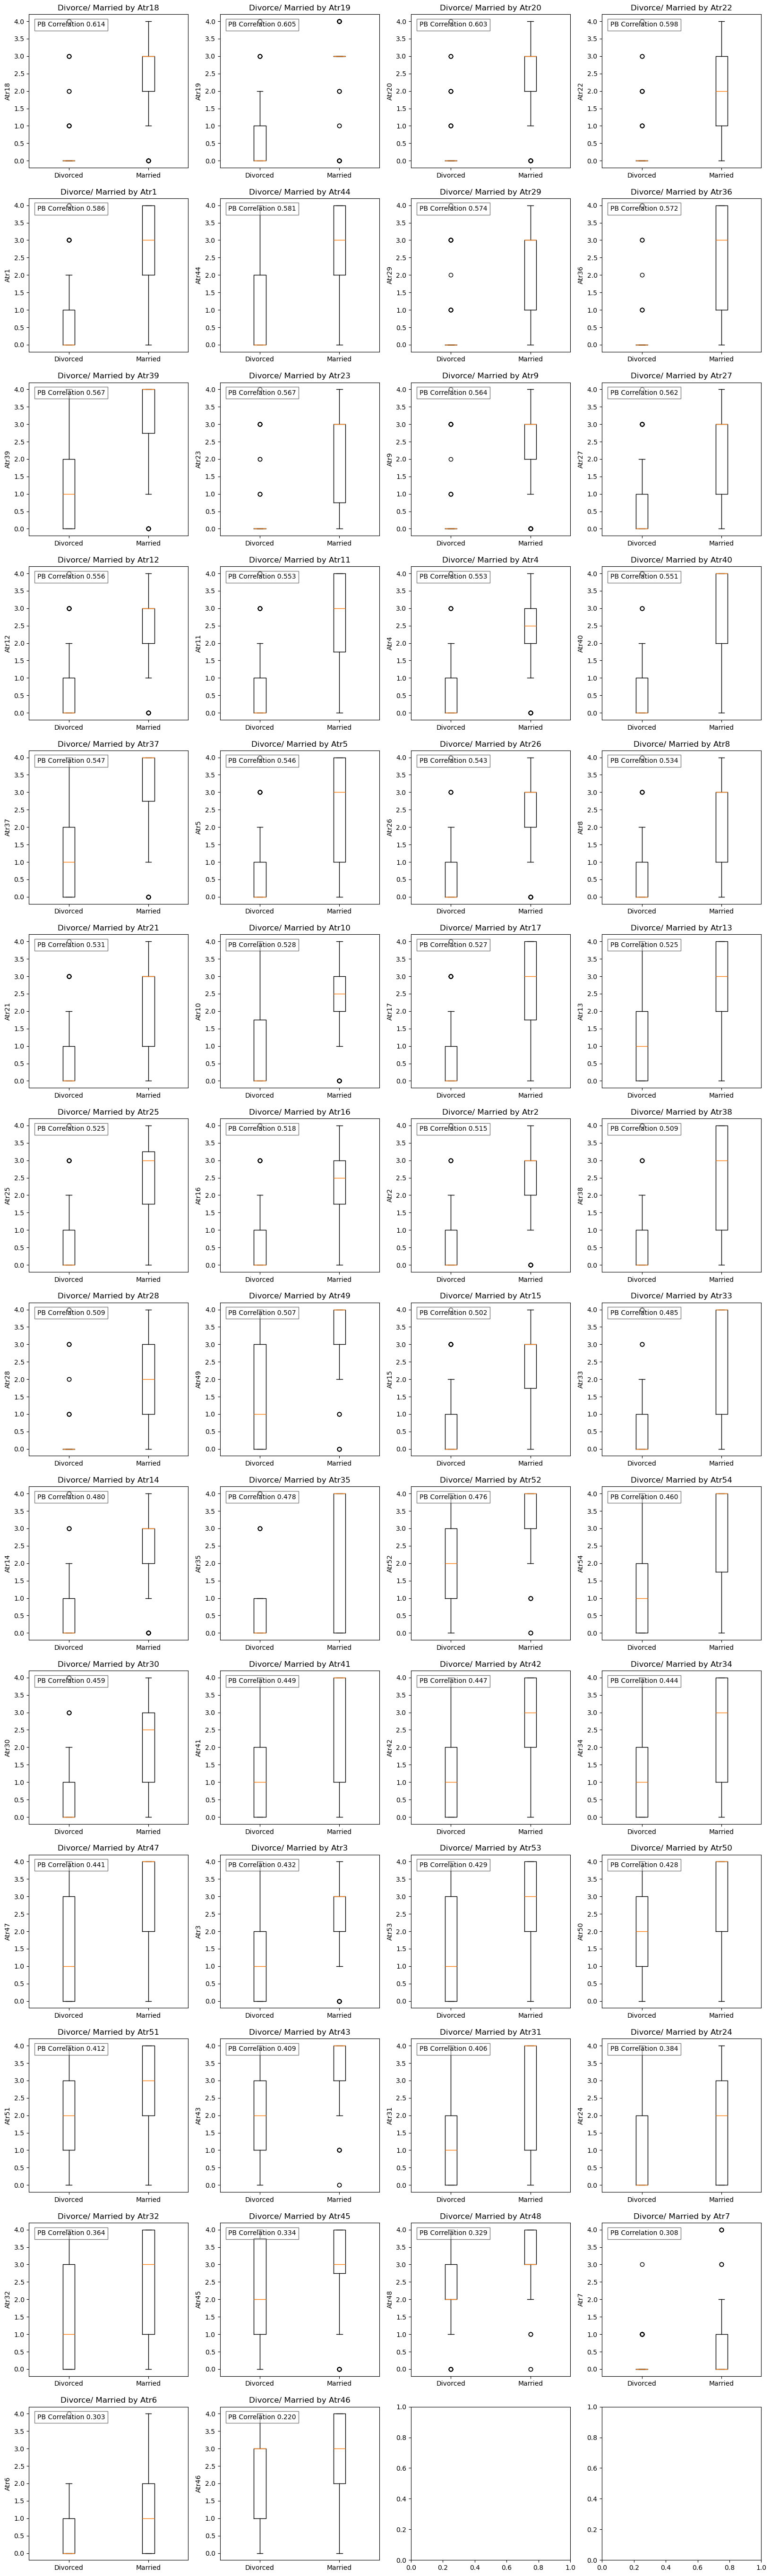

In [13]:
feature_col = corr_pb.index.tolist()
n_cols = 4
n_rows = math.ceil(len(feature_col)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
fig.subplots_adjust(left=0.125, right=0.9, top=0.88, bottom=0.11, wspace=0.2, hspace=0.2)

for i, col in enumerate(feature_col):
    data = [df[df['Class']==0][col], df[df['Class']==1][col]]
    axes[i//4, i%4].boxplot(data, labels=['Divorced', 'Married'])
    axes[i//4, i%4].set_ylabel(col)
    axes[i//4, i%4].set_title(f'Divorce/ Married by {col}')
    axes[i//4, i%4].text(1.03, 3.9, f'PB Correlation {corr_pb[col]:.3f}', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

### 5. Modelling ###

This is a supervised binary classification problem. We will train multiple classification models and select the best model to proceed. 

### 6. Define features & target variable

In [14]:
# Define features and target variable
X = df.drop(columns = ['Class'])
y = df['Class']

### 7. Instantiate and Fit Model(s) ###

In [15]:
# Instantiate each base estimator
lr = LogisticRegression()
svc = SVC(probability=True)
knn = KNeighborsClassifier()
gnb = GaussianNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

bagging_lr = BaggingClassifier(estimator = lr)
bagging_svc = BaggingClassifier(estimator = svc)
bagging_gnb = BaggingClassifier(estimator = gnb)
bagging_dt = BaggingClassifier(estimator = dt)

adaboost_lr = AdaBoostClassifier(estimator = lr)
adaboost_svc = AdaBoostClassifier(estimator = svc)
adaboost_gnb = AdaBoostClassifier(estimator = gnb)
adaboost_dt = AdaBoostClassifier(estimator = dt)

# Normally we don't perform bagging or boosting to KNN, because KNN makes predictions based on the entire training dataset rather than building
# an explicit model. This characteristic leads to some challenges when using ensemble methods like Bagging and Boosting

gradientboosting = GradientBoostingClassifier()     # Gradient Boosting on Decision Trees

base_estimators = [('knn', knn), ('gnb', gnb), ('rf', rf)]
stacking = StackingClassifier(estimators = base_estimators, final_estimator = lr, cv=3)

In [16]:
models = [lr, bagging_lr, adaboost_lr, svc, bagging_svc, adaboost_svc, knn, gnb, bagging_gnb, adaboost_gnb, dt, bagging_dt, adaboost_dt, gradientboosting, rf, stacking]

labels = ['Logistic Regression', 'Bagging LR', 'AdaBoost LR', 'SVC', 'Bagging SVC', 'AdaBoost SVC', 'K-NN', 'GaussianNB', 'Bagging GNB', 'AdaBoost GNB', 'Decision Trees', 'Bagging DT', 'AdaBoost DT', 'Gradient Boosting', 'Random Forest', 'Stacking Classifier']
accuracy = []
stdev = []
run_time = []

for model in models:
    start_time = time.time()
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    end_time = time.time()
    accuracy.append(round(scores.mean(), 4))
    stdev.append(f"+/- {scores.std():.4f}")
    processing_time = end_time - start_time
    run_time.append(round(processing_time, 3))

models_df = pd.DataFrame({'Model':labels, 'Accuracy': accuracy, 'Stdev': stdev, 'Processing time (s)': run_time})
models_df

,Model,Accuracy,Stdev,Processing time (s)
0,Logistic Regression,0.9765,+/- 0.0082,0.021
1,Bagging LR,0.9825,+/- 0.0143,0.093
2,AdaBoost LR,0.9765,+/- 0.0082,0.020
3,SVC,0.9766,+/- 0.0219,0.012
4,Bagging SVC,0.9764,+/- 0.0086,0.063
5,AdaBoost SVC,0.9708,+/- 0.0298,0.115
6,K-NN,0.9764,+/- 0.0167,0.015
7,GaussianNB,0.9707,+/- 0.0298,0.008
8,Bagging GNB,0.9765,+/- 0.0082,0.034
9,AdaBoost GNB,0.9004,+/- 0.0577,0.111


Among models with highest accuracy and the same stdev, Logistic Regression is chosen as the model for divorce prediction as it is simplest in terms of both implementation and processing time.

### 8. Optimize performance of selected model (if needed)

In [17]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
lr.fit(X_train, y_train)

LogisticRegression()

In [19]:
# performance of current logistic regression model on both training and test data

training_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)

print(f"Accuracy on training data : {training_accuracy:.4f}")
print(f"Accuracy on test data : {test_accuracy:.4f}")

Accuracy on training data : 1.0000
Accuracy on test data : 0.9706


In [20]:
# Inspect parameters of current model
params = lr.get_params()

print("Parameters of current model:")
for param, value in params.items():
    print(f"- {param}:{value}")

Parameters of current model:
- C:1.0
- class_weight:None
- dual:False
- fit_intercept:True
- intercept_scaling:1
- l1_ratio:None
- max_iter:100
- multi_class:auto
- n_jobs:None
- penalty:l2
- random_state:None
- solver:lbfgs
- tol:0.0001
- verbose:0
- warm_start:False


In [21]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # Regularization parameter
    'penalty': ['l1', 'l2'],           # Regularization penalty
    'solver': ['liblinear', 'saga'],   # Solver algorithm
    'max_iter': [50, 100, 200],        # Maximum number of iterations
}

In [22]:
# perform grid_search
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

# get the best model
best_model = grid_search.best_estimator_

C:\Users\S.Khoo\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\S.Khoo\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\S.Khoo\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\S.Khoo\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\S.Khoo\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\S.Khoo\AppData\Local\anaco

In [23]:
# performance of best_model on both training and test data

training_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f"Accuracy on training data : {training_accuracy:.4f}")
print(f"Accuracy on test data : {test_accuracy:.4f}")

Accuracy on training data : 0.9779
Accuracy on test data : 0.9706


Despite experimenting with extreme parameter settings, such as 2000 maximum iterations, the model did not converge. Therefore, we will proceed with the earlier Logistic Regression model, which achieved an accuracy of over 90%. This level of accuracy is sufficient for our problem context, which involves predicting divorce.

### 9. ROC and AUC

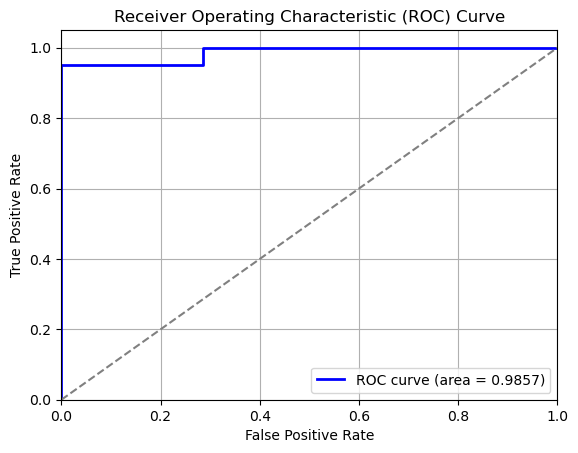

In [24]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- Area under ROC curve ~0.99 (Curve is very close to top-left corner)
- Model has outstanding performance in terms of distinguishing between positive and negative classes.

### 10. Examine features' importance

In [25]:
# get coefficients (weights) of features
coefficients = lr.coef_[0]

In [26]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients, 'Coefficient(abs)': np.abs(coefficients)})
coef_df = coef_df.sort_values(by='Coefficient(abs)', ascending=False).reset_index(drop=True)
print(coef_df)

   Feature  Coefficient  Coefficient(abs)
0    Atr30     0.506821          0.506821
1    Atr44     0.468043          0.468043
2    Atr40     0.457532          0.457532
3    Atr42     0.434503          0.434503
4     Atr1     0.430442          0.430442
5    Atr11     0.397022          0.397022
6    Atr18     0.392593          0.392593
7    Atr25     0.376216          0.376216
8    Atr52     0.362117          0.362117
9    Atr36     0.348962          0.348962
10    Atr6     0.317963          0.317963
11   Atr14     0.310469          0.310469
12   Atr19     0.292337          0.292337
13   Atr35     0.278165          0.278165
14   Atr34     0.271580          0.271580
15   Atr53     0.261419          0.261419
16   Atr31     0.251330          0.251330
17   Atr37     0.244735          0.244735
18    Atr9     0.214103          0.214103
19   Atr15     0.212649          0.212649
20    Atr3     0.204417          0.204417
21   Atr10     0.185203          0.185203
22    Atr2     0.175177          0

### 11. Examine model performance with lesser features

In [27]:
# select features with weight > thresholds

max_coef = (np.floor(np.max(coef_df['Coefficient(abs)']) * 10)) / 10     # if max(coef_df['Coefficient(abs)'])=0.48, max_coef will be 0.4
num_samples = int(max_coef / 0.05) + 1                                   # '+1' adjustment to include endpoint at np.linspace
weight_threshold = np.linspace(0, max_coef, num_samples)
accuracy_mean = []
accuracy_std = []

for threshold in weight_threshold:
    
    selected_features = coef_df.loc[coef_df['Coefficient(abs)'] > threshold, 'Feature']
    selected_features = selected_features.to_list()
    
    X_selected = df[selected_features]
    y = df['Class']
    
    scores = cross_val_score(lr, X_selected, y, cv=3, scoring='accuracy')
    accuracy_mean.append(scores.mean())
    accuracy_std.append(scores.std())

Text(0.5, 1.0, 'Performance of LR model on lesser dataset features')

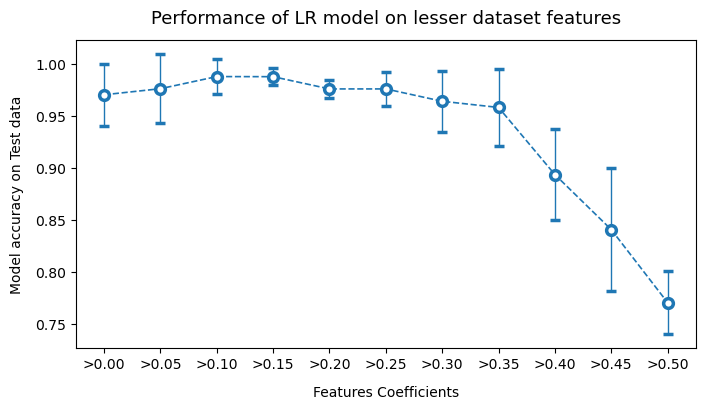

In [28]:
x_values = [x for x in range(len(accuracy_mean))]

plt.figure(figsize = (8,4))
plt.errorbar(x = x_values, y = accuracy_mean, yerr = accuracy_std, linewidth=1, markersize=7, fmt='o', mfc='white', mew=2.5, capsize=3.5, capthick=2.5)
plt.plot(x_values, accuracy_mean, linestyle='--', linewidth=1.2, color='C0')

threshold_labels = [f">{k:.2f}" for k in weight_threshold]
plt.xticks(x_values, threshold_labels)
    
plt.xlabel('Features Coefficients', labelpad=10)
plt.ylabel('Model accuracy on Test data', labelpad=8)
plt.title('Performance of LR model on lesser dataset features', fontsize=13, pad=12)

- Reducing the number of features to those with coefficients >0.35 maintains a significantly high accuracy score for the model. 
- 
It is recommended to include only these questions to streamline the survey proces.


In [29]:
selected_threshold = 0.35
selected_features = coef_df.loc[coef_df['Coefficient(abs)'] > selected_threshold, 'Feature']
selected_features = selected_features.to_list()

X1 = df[selected_features]
y = df['Class']

scores = cross_val_score(lr, X1, y, cv=3, scoring='accuracy')
print(f"Accuracy score on dataset of lesser features: {scores.mean():.4f} +/- {scores.std():.4f}")

Accuracy score on dataset of lesser features: 0.9585 +/- 0.0367


In [30]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2)

In [31]:
lr.fit(X1_train, y1_train)

LogisticRegression()

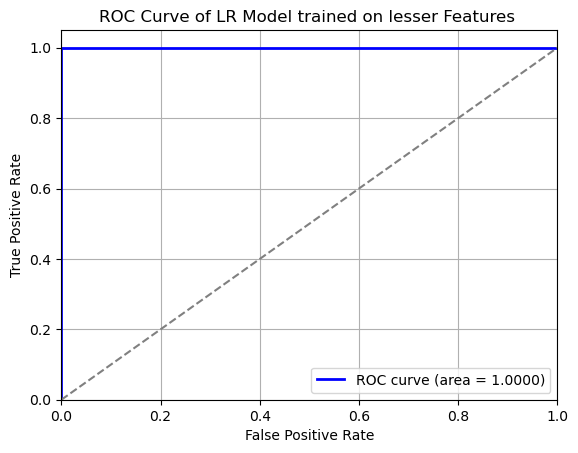

In [32]:
y1_pred_proba = lr.predict_proba(X1_test)[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y1_test, y1_pred_proba)
roc_auc1 = roc_auc_score(y1_test, y1_pred_proba)

plt.figure()
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'ROC curve (area = {roc_auc1:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of LR Model trained on lesser Features ')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- Reducing the number of features to those with coefficients >0.35 maintains a significantly high accuracy score & ROC AUC for the model. 
- It is recommended to include only these questions to streamline the survey process, they are as follow:

    - I know my wife's friends and their social relationships.
    - Sometimes I think t's good for me to leave home for a while.
    - We're just starting a fight before I know what's going on.
    - When I argue with my wife, it only snaps in and I don't say a word.
    - When one of our apologies apologizes when our discussions go in a bad direction, the issue does not extend.
    - I think that one day in the future, when I look back, I see that my wife and I are in harmony with each other.
    - My wife and I have similar ideas about how marriage should be.
    - I have knowledge of my wife's inner world.
    - I wouldn't hesitate to tell her about my wife's inadequacy.

### 12. Summary & Suggestion

#### Successful Model Creation
- We have successfully developed a robust predictive model that accurately identifies at-risk couples early in their relationship. By analyzing comprehensive data, our model provides valuable insights into the factors influencing marital stability and divorce risk, contributing significantly to marital studies and intervention strategies.

#### Suggestions
- Integrate the predictive model into counseling practices to offer data-driven insights for tailored interventions.
- Engage with community organizations and policymakers to advocate for early intervention and supportive policies.